<a href="https://colab.research.google.com/github/vandana10/deeplearning-using-pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch custom datasets

We've used some datasets with PyTorch before..
But how do you get your own data into PyTorch
On way is: Custom datasets



### 0. Importing PyTorch and setting up device agnoatic code

In [5]:
import torch
from torch import nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset

Food101 starts 101 diff classes of food.

Our dataset starts with 3 classes of food and 10% of images(75 praining and 25 testing)

why do this?
First small scale and  then increase when its necessary

In [7]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one..")
  image_path.mkdir(parents=True, exist_ok=True)

#Download pizza steak and sushi data
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza steak and sushi data..")
  f.write(request.content)

#Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data..")
  zip_ref.extractall(image_path)

#Remove zip file
!rm {data_path / "pizza_steak_sushi.zip"}


data/pizza_steak_sushi does not exist, creating one..
Unzipping data..


##2. Becoming one with the data

In [8]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [10]:
#Set up training and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###2.1 Visulizing and image

lets write some code to:
1. get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the time class name usinh pathlib.Path.parent.stem
4. Since we are working with images, lets open the image with python's PIL
5. We'll  then show the image and print metadata

data/pizza_steak_sushi/test/sushi/1230335.jpg
sushi
Image class is: sushi
Image height: 384
Image width: 512


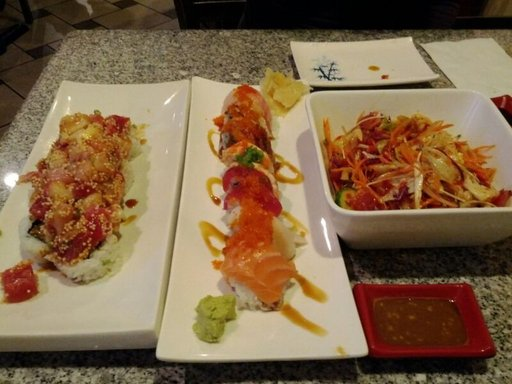

In [11]:
import random
from PIL import Image
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img =Image.open(random_image_path)

print(f"Image class is: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

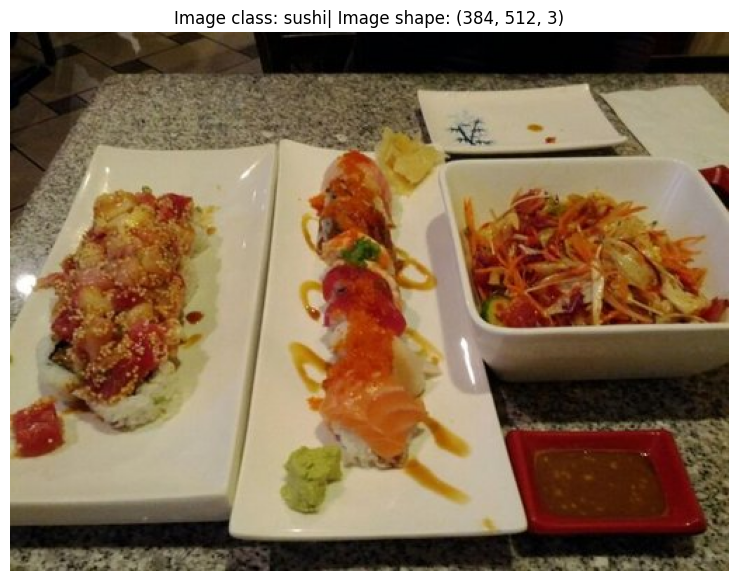

In [12]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}| Image shape: {img_as_array.shape}")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch
1. Turn your target data into tensors(in our case, numerical representation of our images)
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Tranforming data with torchvision.transforms

In [14]:
data_transform = transforms.Compose([
    #Resize our images to 64*64
    transforms.Resize((64,64)),
    #Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
data_transform(img).dtype

torch.float32

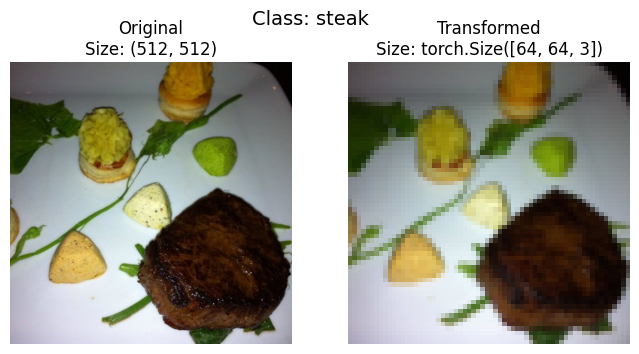

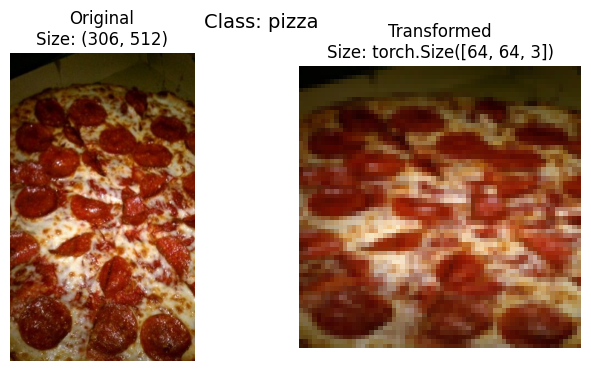

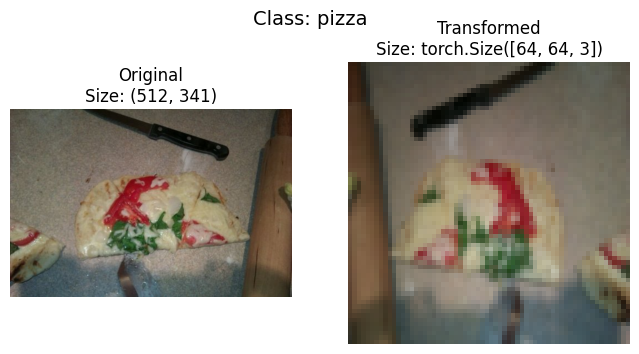

In [16]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Open image
        img = Image.open(image_path)

        # Plot original
        ax[0].imshow(img)
        ax[0].set_title(f"Original\nSize: {img.size}")
        ax[0].axis(False)

        # Transform image
        transformed_image = transform(img).permute(1, 2, 0)  # C,H,W → H,W,C
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
        ax[1].axis(False)

        # Class label (assuming folder name = class name)
        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
        plt.show()

# Example usage:
plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
)


## 4. Option 1: loading image data using image folder

We can load image classificarion data using torchvision.datasets.ImageFolder

In [17]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
#get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [22]:
img, label = train_data[0][0], train_data[0]

Original image shape: torch.Size([3, 64, 64])
Permuted image shape: torch.Size([64, 64, 3])


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

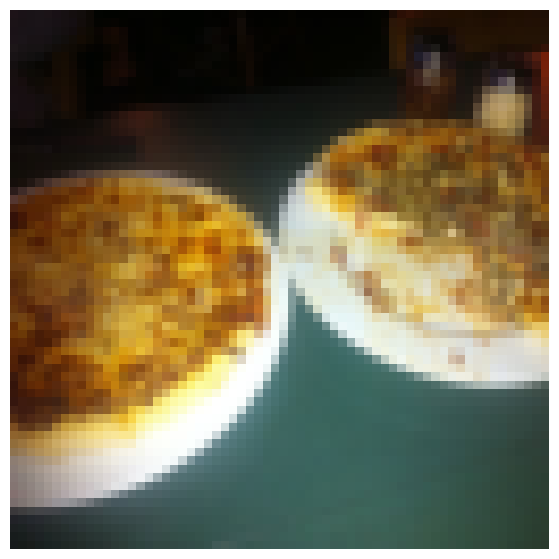

In [23]:
img_permute = img.permute(1, 2, 0)

print(f"Original image shape: {img.shape}")
print(f"Permuted image shape: {img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")


## 4.1 Turn loaded images into `DataLoader's`

A dataLoader is goung to help us turn our datasets into iterables and we can customise the batch_size so our model can see batch_size images at a time.

In [24]:
import os
os.cpu_count()

2

In [25]:
#Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e03644a29f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e03645122a0>)

In [26]:
len(train_dataloader)

225

In [27]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, h, w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, h, w]
Label shape: torch.Size([1])


## % option 2: Loading image data with Custom dataset
1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
1. can create a dataset out of almost everything
2. not limited to PyTorch prebuilt dataset functions

Cons:
1. even though you could create dataset out of almost everything, it doesnt mean it will work
2. Using a custom dataset often results in us writing more code, which could be prone to errors or performance issues

In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [29]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper fucntion to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directory(ideally the directory is in standard image classfication format)
2. Raise an error if class names not found
3. Turn class names into dict and list and return

In [30]:
#Set up directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

#Get class names as a list of strings
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [31]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  #1. Gtet class names
  classes = sorted([entry.name for entry in list(os.scandir(directory))])

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
  return classes, class_to_idx


In [32]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})